In [89]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [90]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

#### Layers

In [91]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x


def cross_entropy_err(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    delta = 1e-7
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = sigmoid(x)
        return self.out

    def backward(self, dout):
        return dout * (1.0 - self.out) * self.out


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        self.x = x
        W, b = self.params
        return np.dot(x, W) + b

    def backward(self, dout):
        W, b = self.params
        self.grads[0][...] = np.dot(self.x.T, dout)
        self.grads[1][...] = np.sum(dout, axis=0)
        return np.dot(dout, W.T)


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        return cross_entropy_err(self.y, self.t)

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        return dx / batch_size

<IPython.core.display.Javascript object>

#### Optimizations

In [92]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

<IPython.core.display.Javascript object>

#### Two Layer net

In [93]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2),
        ]
        self.loss_layer = SoftmaxWithLoss()

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        pred = self.predict(x)
        return self.loss_layer.forward(pred, t)
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout


<IPython.core.display.Javascript object>

#### Load sample dataset

In [94]:
import sys

sys.path.append("..")
from dataset import spiral

x, t = spiral.load_data()
x.shape, t.shape

((300, 2), (300, 3))

<IPython.core.display.Javascript object>

#### Train two net without trainer class

In [95]:
# Hypterparams
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# Load training data
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0.0
loss_cout = 0.0
loss_list = []

<IPython.core.display.Javascript object>

In [96]:
for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters * batch_size : (iters + 1) * batch_size]
        batch_t = t[iters * batch_size : (iters + 1) * batch_size]
        loss = model.forward(batch_x, batch_t)
        #         print(loss)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_cout += 1

        if (iters + 1) % 10 == 0:
            avg_loss = total_loss / loss_cout
            print(
                "| epoch %d | iter %d / %d | loss %.2f"
                % (epoch + 1, iters + 1, max_iters, avg_loss)
            )
            loss_list.append(avg_loss)
            total_loss, loss_cout = 0.0, 0.0

| epoch 1 | iter 10 / 10 | loss 1.13
| epoch 2 | iter 10 / 10 | loss 1.13
| epoch 3 | iter 10 / 10 | loss 1.12
| epoch 4 | iter 10 / 10 | loss 1.12
| epoch 5 | iter 10 / 10 | loss 1.11
| epoch 6 | iter 10 / 10 | loss 1.14
| epoch 7 | iter 10 / 10 | loss 1.16
| epoch 8 | iter 10 / 10 | loss 1.11
| epoch 9 | iter 10 / 10 | loss 1.12
| epoch 10 | iter 10 / 10 | loss 1.13
| epoch 11 | iter 10 / 10 | loss 1.12
| epoch 12 | iter 10 / 10 | loss 1.11
| epoch 13 | iter 10 / 10 | loss 1.09
| epoch 14 | iter 10 / 10 | loss 1.08
| epoch 15 | iter 10 / 10 | loss 1.04
| epoch 16 | iter 10 / 10 | loss 1.03
| epoch 17 | iter 10 / 10 | loss 0.96
| epoch 18 | iter 10 / 10 | loss 0.92
| epoch 19 | iter 10 / 10 | loss 0.92
| epoch 20 | iter 10 / 10 | loss 0.87
| epoch 21 | iter 10 / 10 | loss 0.85
| epoch 22 | iter 10 / 10 | loss 0.82
| epoch 23 | iter 10 / 10 | loss 0.79
| epoch 24 | iter 10 / 10 | loss 0.78
| epoch 25 | iter 10 / 10 | loss 0.82
| epoch 26 | iter 10 / 10 | loss 0.78
| epoch 27 | iter 10 

| epoch 225 | iter 10 / 10 | loss 0.14
| epoch 226 | iter 10 / 10 | loss 0.14
| epoch 227 | iter 10 / 10 | loss 0.14
| epoch 228 | iter 10 / 10 | loss 0.14
| epoch 229 | iter 10 / 10 | loss 0.13
| epoch 230 | iter 10 / 10 | loss 0.14
| epoch 231 | iter 10 / 10 | loss 0.13
| epoch 232 | iter 10 / 10 | loss 0.14
| epoch 233 | iter 10 / 10 | loss 0.13
| epoch 234 | iter 10 / 10 | loss 0.13
| epoch 235 | iter 10 / 10 | loss 0.13
| epoch 236 | iter 10 / 10 | loss 0.13
| epoch 237 | iter 10 / 10 | loss 0.14
| epoch 238 | iter 10 / 10 | loss 0.13
| epoch 239 | iter 10 / 10 | loss 0.13
| epoch 240 | iter 10 / 10 | loss 0.14
| epoch 241 | iter 10 / 10 | loss 0.13
| epoch 242 | iter 10 / 10 | loss 0.13
| epoch 243 | iter 10 / 10 | loss 0.13
| epoch 244 | iter 10 / 10 | loss 0.13
| epoch 245 | iter 10 / 10 | loss 0.13
| epoch 246 | iter 10 / 10 | loss 0.13
| epoch 247 | iter 10 / 10 | loss 0.13
| epoch 248 | iter 10 / 10 | loss 0.13
| epoch 249 | iter 10 / 10 | loss 0.13
| epoch 250 | iter 10 / 1

<IPython.core.display.Javascript object>

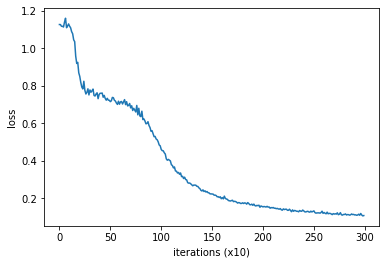

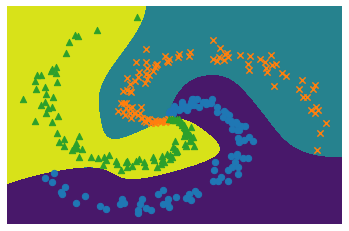

<IPython.core.display.Javascript object>

In [97]:
# 学習結果のプロット
plt.plot(np.arange(len(loss_list)), loss_list, label="train")
plt.xlabel("iterations (x10)")
plt.ylabel("loss")
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis("off")

# データ点のプロット
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ["o", "x", "^"]
for i in range(CLS_NUM):
    plt.scatter(
        x[i * N : (i + 1) * N, 0], x[i * N : (i + 1) * N, 1], s=40, marker=markers[i]
    )
plt.show()

#### Trainer 

In [104]:
import time


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=12, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0.0
        loss_count = 0.0

        start_time = time.time()
        for epoch in range(max_epoch):
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters * batch_size : (iters + 1) * batch_size]
                batch_t = t[iters * batch_size : (iters + 1) * batch_size]

                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    #                     print(iters)
                    print(
                        "| epoch %d |  iter %d / %d | time %d[s] | loss %.2f"
                        % (
                            self.current_epoch + 1,
                            iters + 1,
                            max_iters,
                            elapsed_time,
                            avg_loss,
                        )
                    )
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0.0, 0.0
            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label="train")
        plt.xlabel("iteration (x " + str(self.eval_interval) + ")")
        plt.ylabel("loss")
        plt.show()


def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif (
                    params[i].ndim == 2
                    and params[j].ndim == 2
                    and params[i].T.shape == params[j].shape
                    and np.all(params[i].T == params[j])
                ):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg:
                    break
            if find_flg:
                break

        if not find_flg:
            break

    return params, grads

<IPython.core.display.Javascript object>

| epoch 1 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 2 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 3 |  iter 1 / 10 | time 0[s] | loss 1.13
| epoch 4 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 6 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 7 |  iter 1 / 10 | time 0[s] | loss 1.14
| epoch 8 |  iter 1 / 10 | time 0[s] | loss 1.16
| epoch 9 |  iter 1 / 10 | time 0[s] | loss 1.11
| epoch 10 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 11 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 13 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 14 |  iter 1 / 10 | time 0[s] | loss 1.09
| epoch 15 |  iter 1 / 10 | time 0[s] | loss 1.08
| epoch 16 |  iter 1 / 10 | time 0[s] | loss 1.04
| epoch 17 |  iter 1 / 10 | time 0[s] | loss 1.03
| epoch 18 |  iter 1 / 10 | time 0[s] | loss 0.94
| epoch 19 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 2

| epoch 171 |  iter 1 / 10 | time 0[s] | loss 0.19
| epoch 172 |  iter 1 / 10 | time 0[s] | loss 0.20
| epoch 173 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 174 |  iter 1 / 10 | time 0[s] | loss 0.20
| epoch 175 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 176 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 177 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 178 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 179 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 180 |  iter 1 / 10 | time 0[s] | loss 0.19
| epoch 181 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 182 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 183 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 184 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 185 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 186 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 187 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 188 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 189 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 190 |  iter 1 / 10 | ti

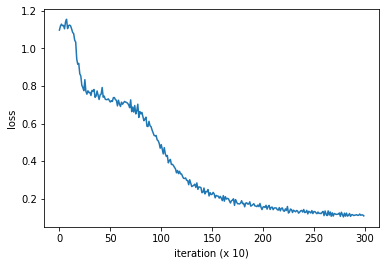

<IPython.core.display.Javascript object>

In [105]:
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
trainer.plot()